## Create Dataset

In [1]:
import math

with open('names.txt') as f:
    names = [name.rstrip('\n') for name in f]

n_train = math.floor(0.8 * len(names)) + 1
n_dev = math.floor(0.9 * len(names)) + 1
trainset = names[:n_train]
devset = names[n_train:n_dev]
testset = names[n_dev:]

len(trainset), len(devset), len(testset)

(25627, 3203, 3203)

## Count Based Trigram Language Model

In addition to the lecture I added another Special token in the beginning of the names, so we can start sampling, as in a trigram we use two chars to predict the next.

In [2]:
import torch
import string

chars = sorted(set(string.ascii_lowercase))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}

trigram_counts = torch.zeros((28, 28, 28), dtype=torch.int32)

for name in trainset:
    chs = ['.', '.'] + list(name) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        trigram_counts[stoi[ch1], stoi[ch2], stoi[ch3]] += 1

trigram_counts[0, 1] # counts of first characters

tensor([  0, 177, 129,  19, 325,  42,  20,  11,  76, 136,  22,  59, 539, 346,
        552,   7,  12,   5, 380, 153,  63, 132, 212,   4,  13, 143, 124,   0],
       dtype=torch.int32)

I can now calculate the probabilites and apply model smoothing. We use the devset to find a good smoothing value.

Mininum at: 0.321052610874176


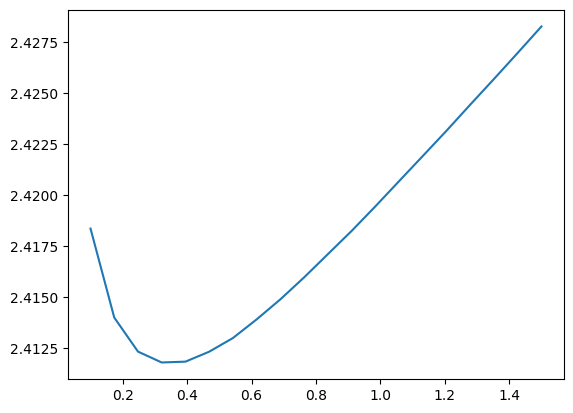

In [3]:
import matplotlib.pyplot as plt

def eval_trigram(names, model):
    ll, n = 0.0, 0
    for name in names:
        chs = ['.', '.'] + list(name) + ['.']
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            prob = model[stoi[ch1], stoi[ch2], stoi[ch3]]
            log_prob = torch.log(prob)
            if log_prob > 1000000:
                print(prob, log_prob)
            ll += log_prob
            n +=1
    return (-ll/n).item()


nlls = [] # nlls for different smoothing values
smoth_vals = torch.linspace(0.1, 1.5, 20)
for i in smoth_vals:
    trigram_probs = (trigram_counts + i).float()
    trigram_probs /= trigram_probs.sum(dim=-1, keepdim=True)
    nll = eval_trigram(devset, trigram_probs)
    nlls.append(nll)

plt.plot(smoth_vals, nlls)
print(f"Mininum at: {smoth_vals[torch.tensor(nlls).argmin()]}")

From now on we use this smoothing value. Lets see if we can beat the bigram model from the lecture on the training set.

In [4]:
smoothing = 0.32
trigram_probs = (trigram_counts + smoothing).float()
trigram_probs /= trigram_probs.sum(dim=-1, keepdim=True)

eval_trigram(trainset, trigram_probs)

2.1571707725524902

Yes even with only 80 percent of the data, the model fits better than the bigram which had a NLL of roughly 2.4. Time to evaluate on the Test set.

In [5]:
eval_trigram(testset, trigram_probs)

2.4325671195983887

Lets also sample some names from this model!

In [6]:
g = torch.Generator().manual_seed(42)
n_samples = 10
for i in range(n_samples):
    ix1 = 0
    ix2 = 0
    while True:
        p = trigram_probs[ix1, ix2]
        ix1 = ix2
        ix2 = torch.multinomial(p, 1, generator=g).item()
        if ix2 == 0:
            break
        print(itos[ix2], end='')
    print()


aisha
solaina
vaada
da
jayashene
alyn
brei
kene
va
farlee


## Neural Net Trigram Language Model

We first create or dataset, using all possible bigrams. Since we will simply index into the weight matrix we dont need one hot encoding.

In [46]:
from itertools import product

chars.append('.')
all_bigrams = set(product(chars, chars))
btoi = {b: i for i, b in enumerate(all_bigrams)}

def prepare_dataset(names):
    xs, ys = [],[],
    for name in names:
        chs = ['.', '.'] + list(name.rstrip('\n')) + ['.']
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            xs.append(btoi[(ch1, ch2)])
            ys.append(stoi[ch3])

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)

    return xs, ys

x_train, y_train = prepare_dataset(trainset)
x_dev, y_dev = prepare_dataset(devset)
x_test, y_test = prepare_dataset(testset)
x_train.shape

torch.Size([182784])

Lets train the a nn with as single layer repeatedly with different regularization weights, in order to find a good weight. I also use cross_entropy loss as it fuses the softmax, so we can apply it directly to the logits.

100%|██████████| 20/20 [00:46<00:00,  2.33s/it]

Mininum at: 0.36315789818763733


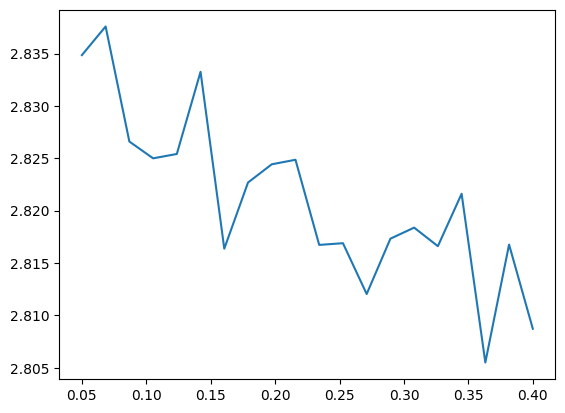

In [53]:
from tqdm import tqdm
import torch.nn.functional as F

g = torch.Generator().manual_seed(42)

def eval_nn(xs, ys):
    with torch.no_grad():
        logits = W[xs]
        loss = F.cross_entropy(logits, ys)
    return loss.item()

def train_step(xs, ys, reg_w):
    # ---- forward pass ----
    logits = W[xs]
    nll = F.cross_entropy(logits, ys)
    reg = reg_w * (W**2).mean()

    loss = nll + reg

    # ---- backward pass -----
    W.grad = None
    loss.backward()
    W.data += -30 * W.grad

    return loss

reg_ws = torch.linspace(5e-2, 0.4, 20)
dev_losses = []
for reg_w in tqdm(reg_ws): 
    epochs = 100
    W = torch.randn((27*27, 27), generator=g, requires_grad=True)

    for _ in range(epochs):
        train_step(x_train, y_train, reg_w)

    nll_dev = eval_nn(x_dev, y_dev)
    dev_losses.append(nll_dev)

plt.plot(reg_ws, dev_losses)
print(f"Mininum at: {reg_ws[torch.tensor(dev_losses).argmin()]}")

Lets use this 0.36 as the regularization weight and train the model longer and see what we can get on the testset.

In [56]:
W = torch.randn((27*27, 27), generator=g, requires_grad=True)

epochs = 10_000
for _ in (pbar := tqdm(range(epochs))):
    loss = train_step(x_train, y_train, 0.36)
    pbar.set_description(f"{loss.item()}")

dev_loss = eval_nn(x_dev, y_dev)
dev_loss

2.3702046871185303: 100%|██████████| 10000/10000 [03:52<00:00, 43.00it/s]


2.480421304702759

In [57]:
test_loss = eval_nn(x_test, y_test)
test_loss

2.4961392879486084

Lets now sample from the model. But instead of using one-hot encoding I used indexing of the weight tensor.

In [58]:
kg = torch.Generator().manual_seed(42)
n_samples = 10
for _ in range(n_samples):
    ix1 = 0
    ix2 = 0
    while True:
        w_row = btoi[(itos[ix1], itos[ix2])]
        with torch.no_grad():
            logits = W[w_row]
            counts = logits.exp()
            probs = counts / counts.sum(dim=-1, keepdim=True) 
        ix1 = ix2
        ix2 = torch.multinomial(probs, 1, generator=g).item()
        if ix2 == 0:
            break
        print(itos[ix2], end='')
    print()

briya
ton
shmbelegigh
ya
lia
kaydy
kenn
mvsma
sit
dleigh
